In [1]:
from matplotlib        import collections             as matcoll
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import rc_context
from scipy.cluster     import hierarchy
from adjustText        import adjust_text

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import math
import glob
import h5py
import sys




import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skbio.stats.composition import clr
from skbio.stats.composition import multiplicative_replacement
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import warnings
warnings.filterwarnings("ignore")

sys.path.append(main_path)
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from data_manipulation.utils import store_data
from IPython.display import clear_output
clear_output()

### Settings

### Manual Test on the CPHFitter

I have change the original code based on the assumption that we have just train(0), test(1), additional(2) datasets. If you want to check use it, be sure about the changes or use survival.py file based on the an extra validation set.

In [2]:
import numpy as np
from decimal import Decimal
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Survival libs.
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter



In [189]:
# Divide group into X buckets.
def get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2):
	labels_buckets = list(range(q_buckets))
	high_lows = list()
	for index, set_data in enumerate(zip(datas, predictions)):
		data, prediction = set_data
		if data[0] is None:
			high_lows.append((None, None, None))
			continue
		current_hazard                     = data[0].copy(deep=True)
		current_hazard['hazard']           = prediction[0]
		if index == 0:
			# median_cutoff is the median hazard value of the train set
			median_cutoff = current_hazard['hazard'].median()
		# If the hazard is higher than the median, it is high risk, otherwise it is low risk.
		current_hazard['h_bin']            = (current_hazard['hazard']>median_cutoff)*1
		current_hazard['h_bin_%s' % fold]  = (current_hazard['hazard']>median_cutoff)*1
		current_low_risk_slides            = current_hazard[current_hazard['h_bin']==labels_buckets[0]][matching_field].values
		current_high_risk_slides           = current_hazard[current_hazard['h_bin']==labels_buckets[1]][matching_field].values

		high_risk_df = current_hazard[current_hazard[matching_field].isin(current_high_risk_slides)].copy(deep=True)
		low_risk_df  = current_hazard[current_hazard[matching_field].isin(current_low_risk_slides)].copy(deep=True)
		high_lows.append((low_risk_df, high_risk_df, current_hazard))
	return high_lows

In [194]:
def plot_KM_high_low(high_risk_df, low_risk_df, ax_title, ax, event_ind_field, event_data_field, max_months=None):
    

    fontsize_title  = 18
    fontsize_labels = 15
    fontsize_ticks  = 15
    fontsize_legend = 14
    l_markerscale   = 8
    l_box_w         = 3
    


    kmf_l = KaplanMeierFitter(label='Low-Risk')
    kmf_l.fit(low_risk_df[event_data_field].astype(float),  event_observed=low_risk_df[event_ind_field].astype(float))
    kmf_h = KaplanMeierFitter(label='High-Risk')
    kmf_h.fit(high_risk_df[event_data_field].astype(float), event_observed=high_risk_df[event_ind_field].astype(float))

    kmf_l.plot_survival_function(show_censors=True, ci_show=True, ax=ax)
    kmf_h.plot_survival_function(show_censors=True, ci_show=True, ax=ax)

    ax.set_title(ax_title)
    ax.set_ylim([0.0,1.10])
    ax.patch.set_linewidth(1)
    if max_months is not None:
        ax.set_xlim([0.0, max_months])
    
    for ticks in [ax.xaxis.get_major_ticks(), ax.yaxis.get_major_ticks()]:
        for tick in ticks:
            tick.label1.set_fontsize(fontsize_ticks)
            tick.label1.set_fontweight('bold')

    
    ax.set_title(ax_title, fontsize=fontsize_title, fontweight='bold', y=1.02)

    ax.set_xlabel('Time (Month)',         fontsize=fontsize_labels, fontweight='bold')
    ax.set_ylabel('Survival Probability', fontsize=fontsize_labels, fontweight='bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)

    legend = ax.legend(loc='best', markerscale=l_markerscale, title='Risk Group', prop={'size': fontsize_legend})
    legend.get_title().set_fontsize(fontsize_legend)
    legend.get_frame().set_linewidth(l_box_w)
    for line in legend.get_lines():
        line.set_linewidth(l_markerscale)


def plot_k_fold_cv_KM(high_risk, low_risk, title, max_months, event_ind_field, event_data_field, file_path=None):
    results = logrank_test(high_risk[event_data_field].astype(float), low_risk[event_data_field].astype(float), event_observed_A=high_risk[event_ind_field].astype(float), event_observed_B=low_risk[event_ind_field].astype(float))
    title_add = 'P-Value: %.2E ' % (Decimal(results.p_value))
    mosaic = '''A'''
    fig = plt.figure(figsize=(15,7), constrained_layout=True)
    ax_dict = fig.subplot_mosaic(mosaic)
    plot_KM_high_low(high_risk, low_risk, ax_title=title + title_add, ax=ax_dict['A'], event_ind_field=event_ind_field, event_data_field=event_data_field, max_months=max_months)
    plt.savefig(file_path, dpi=500, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return results.p_value

def save_fold_KMs(risk_groups, additional_risk, resolution, groupby, cis, event_ind_field, event_data_field, max_months, cox_cluster_path):

    # test_mean = np.round(np.mean(cis[:, 1]), 3)
    test_cindex = np.round(cis[1],2)
    title = 'Leiden %s\nC-Index Test: %s \n' % (resolution, test_cindex)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_test.jpg' % (str(groupby).replace('.', 'p')))
    test_pval = plot_k_fold_cv_KM(risk_groups[1], risk_groups[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    additional_pval = None
    
    # additional_mean = np.round(np.mean(cis[:, 2]), 3)
    additional_cindex = np.round(cis[2],2)
    title = 'Leiden %s\nC-Index Additional (TCGA): %s \n' % (resolution, additional_cindex)
    file_path=os.path.join(cox_cluster_path, 'KM_%s_additional.jpg' % (str(groupby).replace('.', 'p')))
    additional_pval = plot_k_fold_cv_KM(additional_risk[1], additional_risk[0], title=title, max_months=max_months, event_ind_field=event_ind_field, event_data_field=event_data_field, file_path=file_path)

    return test_pval, additional_pval

In [160]:
# Combine Risk Groups over the folds. In the case of additional dataset, mayority vote over folds.
def combine_risk_groups(test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field):
	# For test set, combine the risk groups.
	test_risk[1] = pd.concat([test_risk[1], high_lows[1][1]], ignore_index=True)
	test_risk[0] = pd.concat([test_risk[0], high_lows[1][0]], ignore_index=True)

	# For additional dataset, combine the risk groups.
	if high_lows[2][2] is not None:
		# if fold == 0:
			# additional_risk = pd.concat([additional_risk, high_lows[2][2][[matching_field, event_data_field, event_ind_field]]], ignore_index=True)
			# additional_risk['h_bin_%s'%fold] = high_lows[2][2]['h_bin_%s'%fold].values
		additional_risk[1] = pd.concat([additional_risk[1], high_lows[2][1]], ignore_index=True)
		additional_risk[0] = pd.concat([additional_risk[0], high_lows[2][0]], ignore_index= True)

		if fold == num_folds-1:
			additional_risk['risk'] = (np.mean(additional_risk[['h_bin_%s'%fold for fold in range(num_folds)]], axis=1)>0.5)*1
			high_risk_df = additional_risk[additional_risk[matching_field].isin(additional_risk[additional_risk['risk']==1][matching_field].values)].copy(deep=True)
			low_risk_df  = additional_risk[additional_risk[matching_field].isin(additional_risk[additional_risk['risk']==0][matching_field].values)].copy(deep=True)
			additional_risk     = [low_risk_df, high_risk_df]
	else:
		additional_risk = None
	return test_risk, additional_risk

In [3]:

event_ind_field = 'os_event_ind'
event_data_field = 'os_event_data'
resolution = 2.0
groupby        = 'leiden_%s' % resolution
fold_number = 4
datas = dict()
cis = dict()
cphs = dict()


# For Kaplan-Meier Plots
matching_field = 'case_Id'
num_folds = 5
dataset = 'Meso'
meta_folder = '750K'
figure_path = '{}/workflow/figures/survival/'.format(main_path)
# figure_path = main_path + '/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/cph_{}_{}'.format(dataset, meta_folder, l1_ratio, penalizer)
os.makedirs(figure_path, exist_ok=True)
# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

### Different Resolutions

In [17]:
categorical_data = False
additional = True
resolutions = ['2p0', '1p5', '2p5', '3p0']
# resolutions = ['2p0']
categorical_cols = ['age','TNM_Stage','wcc_score', 'HB_score','smoking_history', 'type', 'Sex']
categorical_cols_additional = ['age']

penalizer = .1
l1_ratio = .5

for resolution in resolutions:
    # remove, hpc = dict_removal[resolution][0], dict_removal[resolution][1]
    datas[resolution] = dict()
    cphs[resolution] = dict()
    cis[resolution] = list()
    train_scores, test_scores, additional_scores = [], [], []
    for fold in range(5):
        leiden_clusters = []
        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        train_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

        test_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

        additional_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)
        features = [x for x in test_df_all.columns.tolist() if x.isdigit()]
        leiden_clusters = [str(x) for x in features]

        train_df = train_df_all[leiden_clusters + [matching_field]]
        test_df = test_df_all[leiden_clusters + [matching_field]]
        additional_df = additional_df_all[leiden_clusters + [matching_field]]


        # Adding needed columns: all clusters | partly clusters | categorical data - [os_event_data, os_event_ind]
        # for cluster, removal in zip(hpc, remove):
        #     if not removal: leiden_clusters.append(str(cluster))
    
        if categorical_data: 
            meta_data_column_list = categorical_cols + [event_data_field, event_ind_field, matching_field]
            meta_data_column_list_additional = categorical_cols_additional + [event_data_field, event_ind_field, matching_field]
        else: meta_data_column_list = [event_data_field, event_ind_field, matching_field]

        meta_data = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
        meta_data = meta_data[meta_data_column_list]
        # if additional:
        #     meta_data_additional = pd.read_csv('{}/files/TCGA_files/clinical_TCGA_clean.csv'.format(main_path))
        #     meta_data_additional = meta_data_additional[meta_data_column_list_additional]

        train_df = pd.merge(train_df, meta_data, on='case_Id', how='inner')
        test_df = pd.merge(test_df, meta_data, on='case_Id', how='inner')
        for df in [train_df, test_df]:
            df.fillna(-1, inplace=True)
            df.replace('-', df.os_event_data.max(), inplace=True)
            df.os_event_data = df.os_event_data.astype(float)

        # if additional: additional_df = pd.merge(additional_df, meta_data, on='case_Id', how='inner')
        if additional: additional_df = additional_df_all
        else: additional_df = None


        datas[resolution][fold] = [(train_df,'train'), (test_df, 'test'), (additional_df, 'additional')]

        if categorical_data:           
            # data_onehot_train = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
            # data_onehot_test = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)
            for df in [train_df, test_df]:
                df['type'] = df['type'].map({'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1})
                df['smoking_history'] = df['smoking_history'].map({'Unknown':-1 , 'Non-smoker': 0, 'Ex-smoker': 1, 'Current-smoker': 2})
                df['HB_score'] = df['HB_score'].map({'Low': 0, 'Normal': 1, 'High': 2, '99': -1})
                df['wcc_score'] = df['wcc_score'].map({'Low': 0, 'Normal': 1, 'High': 2, 'Unknown': -1})
                df['TNM_Stage'] = df['TNM_Stage'].map({'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1})
                df['Sex'] = df['Sex'].map({'Male':0, 'Female':1})
                df['age'] = df['age'].astype(float)
                df.fillna(-1, inplace=True)

            cph.fit(train_df, duration_col='os_event_data', event_col='os_event_ind', robust=True)
            train_scores.append(cph.score(train_df, scoring_method='concordance_index'))
            test_scores.append(cph.score(test_df, scoring_method='concordance_index'))
            if additional: additional_scores.append(cph.score(additional_df, scoring_method='concordance_index'))

        else:
            train_df.drop(matching_field, axis=1, inplace=True)
            test_df.drop(matching_field, axis=1, inplace=True)
            if additional: additional_df.drop(matching_field, axis=1, inplace=True)

            cph.fit(train_df, duration_col='os_event_data', event_col='os_event_ind', robust=True)
            train_scores.append(cph.score(train_df, scoring_method='concordance_index'))
            test_scores.append(cph.score(test_df, scoring_method='concordance_index'))
            if additional: additional_scores.append(cph.score(additional_df, scoring_method='concordance_index'))
        cphs[resolution][fold] = cph
    cis[resolution].append(train_scores)
    cis[resolution].append(test_scores)
    if additional: cis[resolution].append(additional_scores)

# Save to CSV.
if additional: columns = ['Leiden Resolution', 'Fold', 'Train', 'Test', 'Additional']
else: columns = ['Leiden Resolution', 'Fold', 'Train', 'Test']
cis_df = pd.DataFrame(columns=columns)
for resolution in resolutions:
    for fold in range(5):
        if additional: temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], cis[resolution][2][fold]]], columns=columns)
        else: temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold]]], columns=columns)
        # temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], cis[resolution][2][fold]]], columns=columns)
        # temp_row = pd.DataFrame([[resolution, fold, cis[resolution][0][fold], cis[resolution][1][fold], 0]], columns=columns)
        cis_df = pd.concat([cis_df, temp_row], ignore_index=True)

df_mean = cis_df.groupby(['Leiden Resolution']).mean().drop('Fold', axis=1).apply(lambda x: np.round(x*100,1))
df_std = cis_df.groupby(['Leiden Resolution']).std().drop('Fold', axis=1).apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()

# from models.clustering.logistic_regression_leiden_clusters import box_plot_auc_results
# box_plot_auc_results(frame=cis_df, columns=columns, path_file=os.path.join(figure_path, 'cph_boxplot.png'))




,Leiden Resolution,Train,Test,Additional
0,1p5,67.1 ± 0.0,65.5 ± 0.04,65.0 ± 0.02
1,2p0,67.4 ± 0.0,65.2 ± 0.03,64.2 ± 0.01
2,2p5,68.1 ± 0.01,66.0 ± 0.04,65.5 ± 0.02
3,3p0,68.7 ± 0.01,65.1 ± 0.03,64.9 ± 0.02


#### Some clusters (fixed fold=4)

model,lifelines.CoxPHFitter
duration col,'os_event_data'
event col,'os_event_ind'
penalizer,0.5
l1 ratio,0.1
robust variance,True
baseline estimation,breslow
number of observations,512
number of events observed,483
partial log-likelihood,-2534.89
time fit was run,2024-08-02 13:11:37 UTC


<Axes: xlabel='log(HR) (95% CI)'>

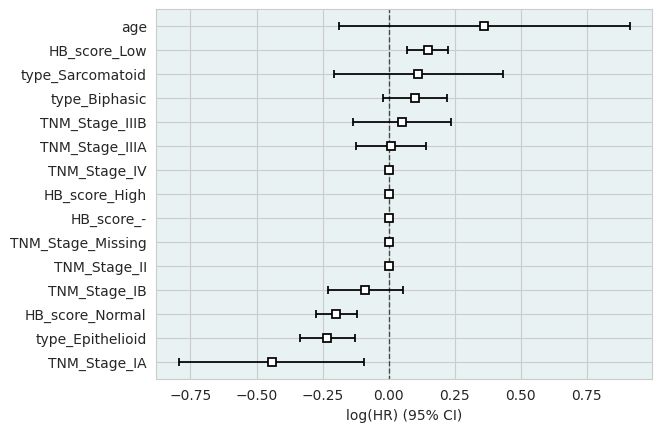

In [129]:
cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
meta_data = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
event_data_field = 'os_event_data'
event_ind_field = 'os_event_ind'

# event_data_field = 'time_to_recurrence'
# event_ind_field = 'recurrence'

columns = ['age', 'type', 'HB_score', 'TNM_Stage', event_data_field, event_ind_field]

meta_data = meta_data[columns]
meta_data = pd.get_dummies(meta_data, columns=['type', 'TNM_Stage', 'HB_score'], drop_first=False)
meta_data['age'] = meta_data['age'] / meta_data['age'].max()
# meta_data['type'] = meta_data['type'].map({'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1})
# meta_data['smoking_history'] = meta_data['smoking_history'].map({'Unknown':-1 , 'Non-smoker': 0, 'Ex-smoker': 1, 'Current-smoker': 2})
# meta_data['HB_score'] = meta_data['HB_score'].map({'Low': 0, 'Normal': 1, 'High': 2, '99': -1})
# meta_data['wcc_score'] = meta_data['wcc_score'].map({'Low': 0, 'Normal': 1, 'High': 2, 'Unknown': -1})
# meta_data['TNM_Stage'] = meta_data['TNM_Stage'].map({'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1})
# meta_data['Sex'] = meta_data['Sex'].map({'Male':0, 'Female':1})
#  add a zero column
meta_data.replace('-', 255, inplace=True)
meta_data[event_data_field] = meta_data[event_data_field].astype(float)
meta_data.fillna(-1, inplace=True)
cph.fit(meta_data, duration_col=event_data_field, event_col=event_ind_field, robust=True)
cph.print_summary()
cph.plot()
# cph.check_assumptions(meta_data, p_value_threshold=0.05, show_plots=True);

### MesoGraph Data

In [15]:
# main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
# import warnings
# warnings.filterwarnings("ignore")

# import torch.optim as optim
# import torch.nn as nn
# from torch.autograd import Variable

# import sys
# sys.path.append(main_path)
# from models.evaluation.folds import load_existing_split
# from models.clustering.correlations import *
# from models.clustering.data_processing import *
# from data_manipulation.utils import store_data
# from IPython.display import clear_output
# clear_output()


# main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
# dataset = 'Meso'
# h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
# frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')
# frame

Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/hdf5_Meso_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['HB_score', 'Meso_type', 'N_stage', 'Sex', 'TNM_Stage', 'T_Stage', 'age', 'case_Id', 'chest_wall_involvement', 'confident_diagnosis', 'desmoplastic_component', 'diaphragm_involvement', 'haemoglobin', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'lung_involvement', 'original_set', 'os_event_data', 'os_event_ind', 'patterns', 'recurrence', 'rib_involvement', 'samples', 'side', 'slides', 'smoking_history', 'tiles', 'time_to_recurrence', 'type', 'wcc_score']>


,0,1,2,3,4,5,6,7,8,9,...,recurrence,rib_involvement,samples,side,slides,smoking_history,tiles,time_to_recurrence,type,wcc_score
0,-0.709269,0.671498,-0.304122,0.308357,-1.582091,-0.230944,1.065236,-1.458449,-0.506369,0.181252,...,1,not_in_resection,MESO_340_2,Right,MESO_340_2,Ex-smoker,48_28.jpeg,6,Biphasic,Normal
1,-0.193634,-0.576174,-0.059378,1.125120,-0.215193,0.776750,0.282445,-1.506880,-1.431857,0.040400,...,1,not_in_resection,MESO_334_17,Left,MESO_334_17,Ex-smoker,3_25.jpeg,10,Epithelioid,Normal
2,0.256981,0.149273,-0.555738,0.235500,-0.467947,-0.032868,0.541816,0.322831,0.191456,-0.429706,...,0,not_in_resection,MESO_271_4,Left,MESO_271_4,Ex-smoker,35_8.jpeg,1,Epithelioid,Normal
3,0.495569,0.926899,0.920012,1.057397,-0.416978,0.936155,0.938385,0.368049,-0.400236,-1.089106,...,0,not_in_resection,MESO_244_14,Left,MESO_244_14,Unknown,49_14.jpeg,2,Epithelioid,Normal
4,1.095177,0.707175,0.963875,-0.375069,1.932813,-1.047360,0.160816,-2.020444,0.939664,-1.224893,...,0,not_in_resection,MESO_92_6,Left,MESO_92_6,Never smoked,42_23.jpeg,1,Epithelioid,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239934,0.800766,-1.198540,-1.837249,2.636246,0.513596,-0.140944,2.433127,-2.238369,3.312950,-1.143912,...,0,not_in_resection,MESO_160_11,Right,MESO_160_11,Unknown,54_10.jpeg,0,Epithelioid,Normal
3239935,-0.265051,-1.525157,0.204506,-1.031049,1.004115,0.556480,0.752053,0.868753,0.284669,0.479023,...,0,not_in_resection,MESO_111_1,Left,MESO_111_1,Never smoked,37_18.jpeg,6,Epithelioid,Normal
3239936,0.342123,0.643209,-0.485781,-1.075883,0.621619,-0.673927,-0.504776,-0.834717,0.435769,0.329138,...,0,not_in_resection,MESO_145_18,Right,MESO_145_18,Unknown,23_8.jpeg,6,Epithelioid,Normal
3239937,-1.592058,-1.402434,-0.370218,0.259508,-0.852418,-0.428687,-0.544881,-0.227725,-0.161204,0.622491,...,0,not_in_resection,MESO_111_1,Left,MESO_111_1,Never smoked,33_26.jpeg,6,Epithelioid,Normal


Quick Test On Simple Survival model (Traditional Method)

In [11]:
import pandas as pd
meta_data_org = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
# meta_data_org = meta_data_org[['case_Id', 'Stage', 'type', 'age', 'smoking_history', 'Sex', 'HB_score', 'wcc_score','TNM_Stage']]
meta_data_org = meta_data_org[['os_event_data', 'os_event_ind', 'age','TNM_Stage','wcc_score', 'HB_score','smoking_history', 'type', 'Sex', 'recurrence']]
# make the table recurrence free
# meta_data_org = meta_data_org[meta_data_org['recurrence'] == 0]
# meta_data_org = meta_data_org[['os_event_data', 'os_event_ind', 'type']]
meta_data_org = meta_data_org.replace({'os_event_data': {'-': meta_data_org['os_event_data'].max()}, 'type': {'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1}})
meta_data_org.os_event_data = meta_data_org.os_event_data.astype(float) #impartant!


# meta_data_org['type'] = meta_data_org['type'].map({'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1})
# meta_data_org['Stage'] = meta_data_org['Stage'].map({'N0': 0, 'N1': 1, 'N2': 2, 'N3': 3})
meta_data_org['smoking_history'] = meta_data_org['smoking_history'].map({'Unknown':-1 , 'Non-smoker': 0, 'Ex-smoker': 1, 'Current-smoker': 2})

meta_data_org['HB_score'] = meta_data_org['HB_score'].map({'Low': 0, 'Normal': 1, 'High': 2, '99': -1})
meta_data_org['wcc_score'] = meta_data_org['wcc_score'].map({'Low': 0, 'Normal': 1, 'High': 2, 'Unknown': -1})
meta_data_org['TNM_Stage'] = meta_data_org['TNM_Stage'].map({'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1})
meta_data_org['Sex'] = meta_data_org['Sex'].map({'Male':0, 'Female':1})
# normalize age column to 0-1
meta_data_org['age'] = (meta_data_org['age'] - meta_data_org['age'].min()) / (meta_data_org['age'].max() - meta_data_org['age'].min())


# adding score df
# meta_data_org = pd.merge(meta_data_org, score_df, on='case_Id', how='inner')

# meta_data_org = meta_data_org.drop('case_Id', axis=1)
# meta_data_org = meta_data_org.replace('-', meta_data_org['os_event_data'].max() )
meta_data_org = meta_data_org.fillna(-1)


from lifelines import CoxPHFitter, KaplanMeierFitter

# Using Cox Proportional Hazards model
penalizer = .1
l1_ratio = .05
cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
cph.fit(meta_data_org, 'os_event_data', event_col='os_event_ind')
cph.print_summary()
ax1 = cph.plot()
plt.show()

# Using Cox Proportional Hazards model and get kaplan meier plot by HR>median and HR<median
kmf = KaplanMeierFitter()
high_risk_group = meta_data_org[meta_data_org['type'] == 2]
medium_risk_group = meta_data_org[meta_data_org['type'] == 1]
low_risk_group = meta_data_org[meta_data_org['type'] == 0]

kmf.fit(high_risk_group['os_event_data'], high_risk_group['os_event_ind'], label='Sarcomatoid')
ax = kmf.plot()
kmf.fit(medium_risk_group['os_event_data'], medium_risk_group['os_event_ind'], label='Biphasic')
kmf.plot(ax=ax)
kmf.fit(low_risk_group['os_event_data'], low_risk_group['os_event_ind'], label='Epithelioid')
kmf.plot(ax=ax)
plt.show()


# Using Cox Proportional Hazards model and get kaplan meier plot by just src/biph and epi
kmf = KaplanMeierFitter()
high_risk_group = meta_data_org[meta_data_org.type.apply(lambda x:x in [1,2])]
low_risk_group = meta_data_org[meta_data_org['type'] == 0]

kmf.fit(high_risk_group['os_event_data'], high_risk_group['os_event_ind'], label='Sarcomatoid/Biphasic')
ax2 = kmf.plot()
kmf.fit(low_risk_group['os_event_data'], low_risk_group['os_event_ind'], label='Epithelioid')
kmf.plot(ax=ax2)


ConvergenceError: delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

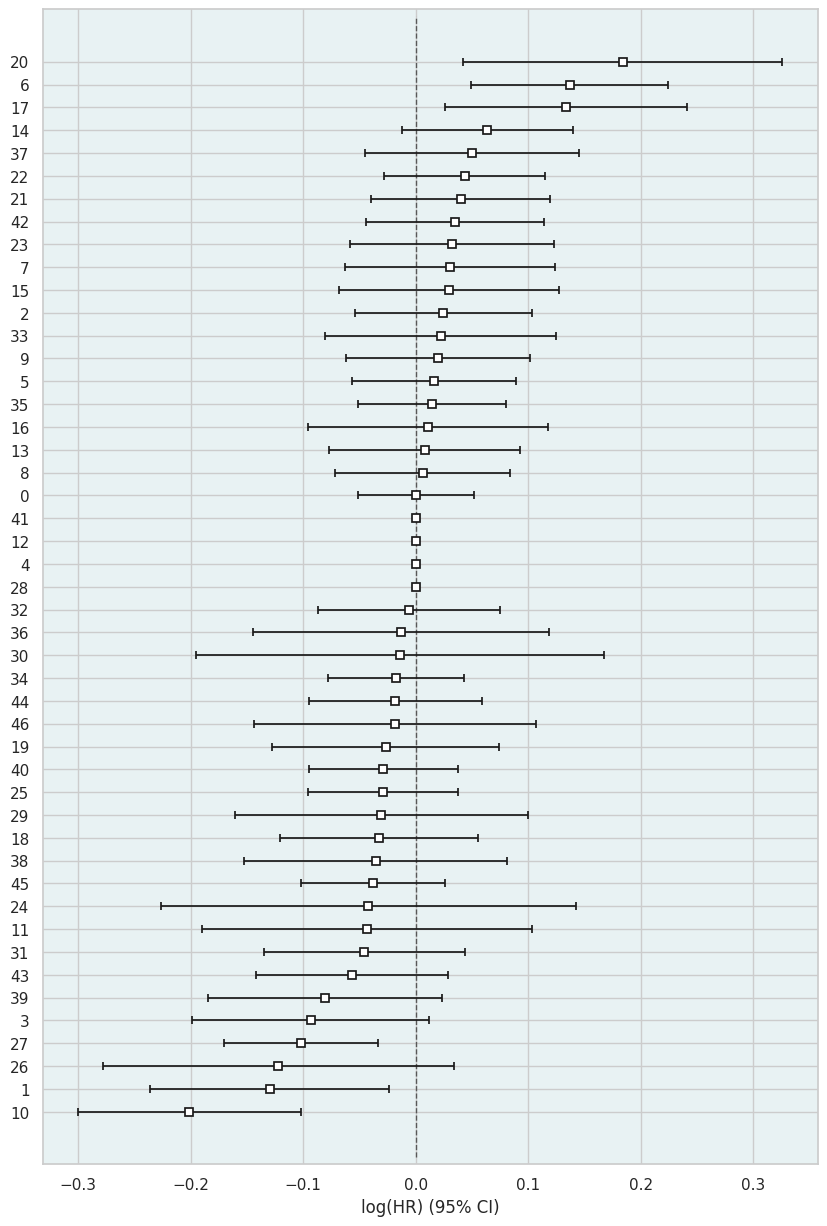

In [43]:
resolution = '2p0'
fold = 4
meta_data_org = pd.read_csv('{}/files/Meso_patients.csv'.format(main_path))
meta_data_org = meta_data_org[['os_event_data', 'os_event_ind', 'age','TNM_Stage','wcc_score', 'HB_score','smoking_history', 'type', 'Sex', 'case_Id']]


train_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

# test_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/750K/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, resolution, fold), index_col=0)

# additional_df_all = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/750K/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, resolution, fold), index_col=0)

# Just take the clusters
leiden_clusters = [str(x) for x in train_df_all.columns.tolist() if x.isdigit()]
train_df_all = train_df_all[leiden_clusters+['case_Id']]

# make the meta data ready for the model
meta_data_org = meta_data_org.replace({'os_event_data': {'-': meta_data_org['os_event_data'].max()}, 'type': {'Epithelioid': 0, 'Sarcomatoid': 2, 'Biphasic': 1}})
meta_data_org.os_event_data = meta_data_org.os_event_data.astype(float) #impartant!
meta_data_org['smoking_history'] = meta_data_org['smoking_history'].map({'Unknown':-1 , 'Non-smoker': 0, 'Ex-smoker': 1, 'Current-smoker': 2})
meta_data_org['HB_score'] = meta_data_org['HB_score'].map({'Low': 0, 'Normal': 1, 'High': 2, '99': -1})
meta_data_org['wcc_score'] = meta_data_org['wcc_score'].map({'Low': 0, 'Normal': 1, 'High': 2, 'Unknown': -1})
meta_data_org['TNM_Stage'] = meta_data_org['TNM_Stage'].map({'IA': 0, 'IB':.5, 'II': 1, 'IIIA': 2, 'IIIB': 2.5, 'IV': 3, 'Missing': -1})
meta_data_org['Sex'] = meta_data_org['Sex'].map({'Male':0, 'Female':1})


# merge the dataframes (meta data and the clusters)
df = train_df_all.merge(meta_data_org, on='case_Id', how='inner')
df = df.drop('case_Id', axis=1)
df = df.fillna(-1)


# Using Cox Proportional Hazards model
penalizer = .1
l1_ratio = .05
cph_good = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
cph_good.fit(df, 'os_event_data', event_col='os_event_ind')
# summary = cph.print_summary()
# plot the model
fig, ax = plt.subplots(figsize=(10, 15))
sns.set_theme(style='white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.facecolor"] = '#f3e9de'
ax = cph.plot()
plt.show()


In [126]:
from torch import nn
import torch
import torch.nn.functional as F

class GatedAttention(nn.Module):
    def __init__(self, input_dim, att_dim):
        super(GatedAttention, self).__init__()
        self.M = input_dim
        self.L = att_dim
        self.ATTENTION_BRANCHES = 1

        self.attention_V = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid()
        )

        self.attention_w = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = nn.Sequential(
            nn.Linear(self.M*self.ATTENTION_BRANCHES, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)
        x = x.squeeze(1)

        A_V = self.attention_V(x)  # KxL
        A_U = self.attention_U(x)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.transpose(A, 1, 0)  # ATTENTION_BRANCHESxK
        A = F.softmax(A, dim=1)  # softmax over K

        Z = torch.mm(A, x)  # ATTENTION_BRANCHESxM

        # Y_prob = self.classifier(Z)
        risk = self.classifier(Z)
        high_risk = torch.ge(risk, 0.3).float()

        return risk, high_risk, A, Z


In [59]:
import torch

import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np

class CsvBags(torch.utils.data.Dataset):
    def __init__(self, csv, meta_columns=['case_Id']):
        self.csv = csv
        self.meta_columns = meta_columns
        self.bags, self.event_times, self.censored, self.labels, self.metadata = self._create_bag()


    def __len__(self):
        return len(self.bags)

    def _create_bag(self):
        bag_list = []
        event_times = []
        censored = []
        metadata = []
        labels = []
        for bag in self.csv['case_Id'].unique():
            bag_df = self.csv[self.csv['case_Id']==bag]
            bag_list.append(torch.from_numpy(bag_df.drop(['case_Id', 'os_event_data', 'os_event_ind','Meso_type']+self.meta_columns, axis=1).values).unsqueeze(1))
            event_times.append(bag_df['os_event_data'].iloc[0])
            censored.append(bag_df['os_event_ind'].iloc[0])
            labels.append(bag_df['Meso_type'].iloc[0]) # Epithelioid: 0, Biphasic-Sarcomatoid: 1
            metadata.append(bag_df[self.meta_columns].iloc[0].tolist())
        return bag_list, event_times, censored, labels, metadata

    def get_bags_labels(self):
        return self.bags, self.event_times, self.censored, self.labels, self.metadata
    
    def __getitem__(self, idx):
        return self.bags[idx], self.event_times[idx], self.censored[idx], self.labels[idx], self.metadata[idx]   

def make_weighted_loder(dataset):
    from torch.utils.data import WeightedRandomSampler
    # all_labels = torch.tensor([torch.long(t) for t in CsvBags(data, meta_columns=meta_columns).labels], dtype=torch.long)
    all_labels = torch.tensor([int(t) for t in dataset.labels], dtype=torch.long)
    class_counts = torch.bincount(all_labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[all_labels]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=sampler)
    return loader





csv_data = frame.iloc[:,0:128]
meta_columns=['case_Id', 'age','TNM_Stage','wcc_score', 'HB_score']
for col in meta_columns:
    csv_data[col] = frame[col]
csv_data['os_event_data'] = frame['os_event_data'].apply(lambda x: np.inf if x == '-' else x).astype(float) #Fix this as censored
csv_data['os_event_ind'] = frame['os_event_ind'].astype(float)
csv_data['case_Id'] = frame['case_Id']
csv_data['Meso_type'] = frame['Meso_type']
ratio = 0.8
train_df_slides = csv_data['case_Id'].unique()[:int(ratio*len(csv_data['case_Id'].unique()))]
test_df_slides = csv_data['case_Id'].unique()[int(ratio*len(csv_data['case_Id'].unique())):]
train_df = csv_data[csv_data['case_Id'].isin(train_df_slides)]
test_df = csv_data[csv_data['case_Id'].isin(test_df_slides)]

train_dataset = CsvBags(train_df, meta_columns=meta_columns)
test_dataset = CsvBags(test_df, meta_columns=meta_columns)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

train_loader = make_weighted_loder(train_dataset)
test_loader = make_weighted_loder(test_dataset)


In [ ]:

import torch
import numpy as np

def coxph_loss(event_ind, risk_set, predictions):
    pred_t = predictions.t()
    rr = logsumexp_masked(pred_t, risk_set, dim=1, keepdim=True)
    loss = torch.sum(event_ind * (predictions - rr)).mean()
    return loss



def logsumexp_masked(risk_scores, mask, dim=0, keepdim=False):
    """
    Compute logsumexp across `dim` for entries where `mask` is true.
    Args:
        risk_scores (Tensor): The risk scores.
        mask (Tensor): A boolean mask where True indicates the entries to consider.
        dim (int): The dimension over which to compute the logsumexp.
        keepdim (bool): Whether to keep the dimensions of the result.
    Returns:
        Tensor: The result of the logsumexp operation.
    """
    # Convert mask to the same dtype as risk_scores
    mask_f = mask.type_as(risk_scores)
    
    # Apply the mask to the risk scores
    risk_scores_masked = risk_scores * mask_f
    
    # Subtract the maximum value for numerical stability
    max_risk_score = torch.max(risk_scores_masked, dim=dim, keepdim=True).values
    risk_scores_shift = risk_scores_masked - max_risk_score
    
    # Compute the exponential of the shifted scores
    exp_masked = torch.exp(risk_scores_shift) * mask_f
    
    # Sum the exponentials along the specified dimension
    exp_sum = torch.sum(exp_masked, dim=dim, keepdim=True)
    
    # Compute the log of the summed exponentials
    output = max_risk_score + torch.log(exp_sum)
    
    if not keepdim:
        output = output.squeeze(dim)
    
    return output



def make_riskset(time):
    assert time.ndim == 1, '1D array needed'
    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set

mask = make_riskset(np.array([15,21,13,4,5,6,7,8,9,10]))
mask

In [114]:
# Function to create label masks
def create_label_masks(event_times, max_time):
    num_samples = len(event_times)
    
    # Initialize masks with zeros
    max_time = int(max_time)
    label_mask = torch.zeros((num_samples, max_time))
    label_mask_2 = torch.zeros((num_samples, max_time))
    
    for i, event_time in enumerate(event_times):
        event_time = int(event_time)
        
        # Fill label_mask with 1s up to the event time
        label_mask[i, :event_time] = 1
        
        # Fill label_mask_2 with 1s only at the event time
        if event_time < max_time:
            label_mask_2[i, event_time] = 1
    
    return label_mask, label_mask_2

bags, event_times, censored, _,_ = train_dataset.get_bags_labels()
label_mask, label_mask_2 = create_label_masks(event_times, max(event_times))

In [127]:
class SurvivalLoss:
    def __init__(self, alpha, sigma):
        self.alpha = alpha
        self.sigma = sigma

    def log(self, x):
        return torch.log(x + 1e-8)

    def loss_log_likelihood(self, event_time_prob, label_mask, censored):
        part_1 = torch.sum(self.log(event_time_prob * label_mask), dim=-1, keepdim=True)
        part_1 = (1 - censored) * part_1

        part_2 = torch.sum(event_time_prob * label_mask, dim=-1, keepdim=True)
        part_2 = censored * self.log(part_2)

        loss_1 = -torch.mean(part_1 + part_2, dim=0)
        return loss_1

    def loss_ranking(self, event_time_prob, labels, label_mask_2):
        batch_size = labels.shape[0]
        one_vector = torch.ones((batch_size, 1), dtype=torch.float32, device=labels.device)

        # Accumulate risk until time of event.
        # R = torch.matmul(event_time_prob.item(), label_mask_2.t())
        R = event_time_prob.item() * label_mask_2.T
        
        diag_R = torch.diag(R).view(-1, 1)
        
        # Relationship between risks of patients.
        R_diff = diag_R - R

        # Indicator function to find patients with s_i < s_j:
        T = F.relu(torch.sign(torch.matmul(one_vector, labels.t()) - torch.matmul(labels, one_vector.t())))
        
        # Intermediate term
        interm = self.alpha * T * torch.exp(-R_diff / self.sigma)

        loss_2 = torch.mean(interm)
        return loss_2

    def loss(self, event_time_prob, labels, label_mask, label_mask_2, censored):
        loss_1 = self.loss_log_likelihood(event_time_prob, label_mask, censored)
        loss_2 = self.loss_ranking(event_time_prob, labels, label_mask_2)
        loss = loss_1
        return loss, loss_1, loss_2


In [129]:
from lifelines.utils import concordance_index


input_dim = 128  # Dimension of each instance's feature vector
hidden_dim = 64  # Dimension of the hidden layer
model = GatedAttention(input_dim, hidden_dim)
learning_rate = 0.001
weight_decay = 0.001
num_epochs = 10
scores = pd.DataFrame()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fun = SurvivalLoss(alpha=1.0, sigma=1.0)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    # meso_scores, ev_times, censors, labels, high_risks, metas = [], [], [], [], [], []
    risks, ev_times, censors, labels, high_risks, metas = [], [], [], [], [], []
    # for instances, survival_labels in train_loader:
    for instances, event_time_data, censor_data, label, meta_data in train_loader:
        instances = Variable(instances.float())
        event_time_data = Variable(event_time_data.float())
        censor_data = Variable(censor_data)
        label = Variable(torch.tensor([float(label[0])]))
        
        optimizer.zero_grad()
        
        risk, high_risk, attention_score, weighted_instances = model(instances)
        # meso_score, high_risk, attention_score, weighted_instances = model(instances)
        risk = torch.clamp(risk, min=1e-5, max=1. - 1e-5)
        # meso_score = torch.clamp(meso_score, min=1e-5, max=1. - 1e-5)
        # loss = - (censor * (event_time * torch.log(risk) + (1 - event_time) * torch.log(1 - risk)) +
                #   (1 - censor) * torch.log(1 - risk)).mean()
        # loss = - (label * torch.log(meso_score) + (1. - label) * torch.log(1. - meso_score))
        loss = - (label * torch.log(risk) + (1. - label) * torch.log(1. - risk)).mean()
        # loss, loss_1, loss_2 = loss_fun.loss(risk, event_time_data, label_mask, label_mask_2, censor_data)
        train_loss += loss.item()

        risks.append(-risk.item())
        ev_times.append(float(event_time_data))
        censors.append(int(censor_data))
        labels.append(label.item())
        metas.append(meta_data)
        # meso_scores.append(meso_score.item())
        high_risks.append(high_risk.item())

        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    print('Train Set, Epoch: {}, Loss: {:.5f}'.format(epoch, train_loss))
    c_index = concordance_index(ev_times, risks, censors)
    print('Concordance Index: {:.4f}'.format(concordance_index(ev_times, risks, censors)))



# save model for test data and evaluation
# model_ckp = model.state_dict()


Train Set, Epoch: 0, Loss: 0.44659
Concordance Index: 0.6168
Train Set, Epoch: 1, Loss: 0.36011
Concordance Index: 0.6036
Train Set, Epoch: 2, Loss: 0.32843
Concordance Index: 0.6160
Train Set, Epoch: 3, Loss: 0.24969
Concordance Index: 0.6046
Train Set, Epoch: 4, Loss: 0.29566
Concordance Index: 0.6335
Train Set, Epoch: 5, Loss: 0.28022
Concordance Index: 0.6050
Train Set, Epoch: 6, Loss: 0.32396
Concordance Index: 0.6180
Train Set, Epoch: 7, Loss: 0.26090
Concordance Index: 0.6501
Train Set, Epoch: 8, Loss: 0.25675
Concordance Index: 0.6389
Train Set, Epoch: 9, Loss: 0.24877
Concordance Index: 0.6452


In [ ]:

model_test = GatedAttention(input_dim, hidden_dim)
# model_test.load_state_dict(model_ckp)
model_test.eval()
test_loss = 0.
risks, ev_times, censors, labels, high_risks, metas = [], [], [], [], [], []
for instances, event_time_data, censor_data, label, meta_data in test_loader:
    instances = Variable(instances.float())
    event_time_data = Variable(event_time_data.float())
    censor_data = Variable(censor_data)
    label = Variable(torch.tensor([float(label[0])]))
    
    risk, high_risk, attention_score, weighted_instances = model_test(instances)
    risk = torch.clamp(risk, min=1e-5, max=1. - 1e-5)
    loss = - (label * torch.log(risk) + (1. - label) * torch.log(1. - risk)).mean()
    test_loss += loss.item()

    risks.append(-risk.item())
    ev_times.append(float(event_time_data))
    censors.append(int(censor_data))
    labels.append(label.item())
    metas.append(meta_data)
    high_risks.append(high_risk.item())

test_loss /= len(test_loader)
print('Test Set, Loss: {:.5f}'.format(test_loss))
print('Concordance Index: {:.4f}'.format(concordance_index(ev_times, risks, censors)))

In [110]:
# test data evaluation
model_test = GatedAttention(input_dim, hidden_dim)
model_test.load_state_dict(model_ckp)
model_test.eval()
test_loss = 0.
risks, ev_times, censors, labels, high_risks, metas = [], [], [], [], [], []
for instances, event_time_data, censor_data, label, meta_data in test_loader:
    instances = Variable(instances.float())
    event_time_data = Variable(event_time_data.float())
    censor_data = Variable(censor_data)
    label = Variable(torch.tensor([float(label[0])]))
    
    risk, high_risk, attention_score, weighted_instances = model_test(instances)
    risk = torch.clamp(risk, min=1e-5, max=1. - 1e-5)
    loss = - (label * torch.log(risk) + (1. - label) * torch.log(1. - risk))
    test_loss += loss.item()

    risks.append(-risk.item())
    ev_times.append(float(event_time_data))
    censors.append(int(censor_data))
    labels.append(label.item())
    metas.append(meta_data)
    high_risks.append(high_risk.item())

test_loss /= len(test_loader)
print('Test Set, Loss: {:.5f}'.format(test_loss))
print('Concordance Index: {:.4f}'.format(concordance_index(ev_times, risks, censors)))


Test Set, Loss: 0.34612
Concordance Index: 0.6144


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          44.05 <0.005     34.86

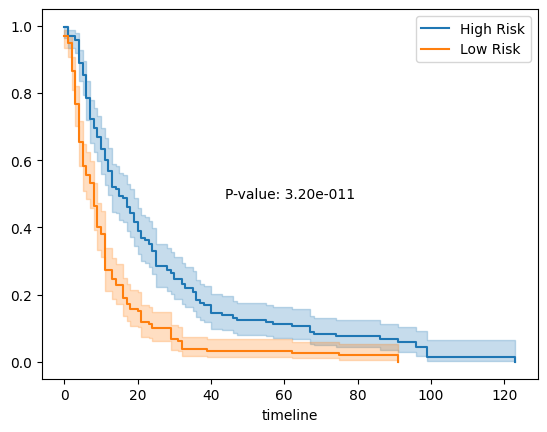

In [108]:
#  save the lists in df
metas_ = [[x[0] for x in X] for X in metas]
df = pd.DataFrame(columns=meta_columns, data=metas_)
df['risk'] = risks
df['os_event_data'] = ev_times
df['os_event_ind'] = censors
df['Meso_type'] = labels
# df['Meso_score'] = meso_scores
# df['Meso_type'] = df['Meso_type'].apply(lambda x: x.item())


kmf = KaplanMeierFitter()
high_risk_group = df[df['risk'] > df['risk'].median()]
low_risk_group = df[df['risk'] <= df['risk'].median()]
kmf.fit(high_risk_group['os_event_data'], high_risk_group['os_event_ind'], label='High Risk')
ax = kmf.plot()
kmf.fit(low_risk_group['os_event_data'], low_risk_group['os_event_ind'], label='Low Risk')
kmf.plot(ax=ax)
# add p-value on the plot
from lifelines.statistics import logrank_test
results = logrank_test(high_risk_group['os_event_data'], low_risk_group['os_event_data'], high_risk_group['os_event_ind'], low_risk_group['os_event_ind'])
results.print_summary()
from numpy import format_float_scientific
ax.text(0.5, 0.5, 'P-value: {}'.format(format_float_scientific(results.p_value, precision=2, exp_digits=3)), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()


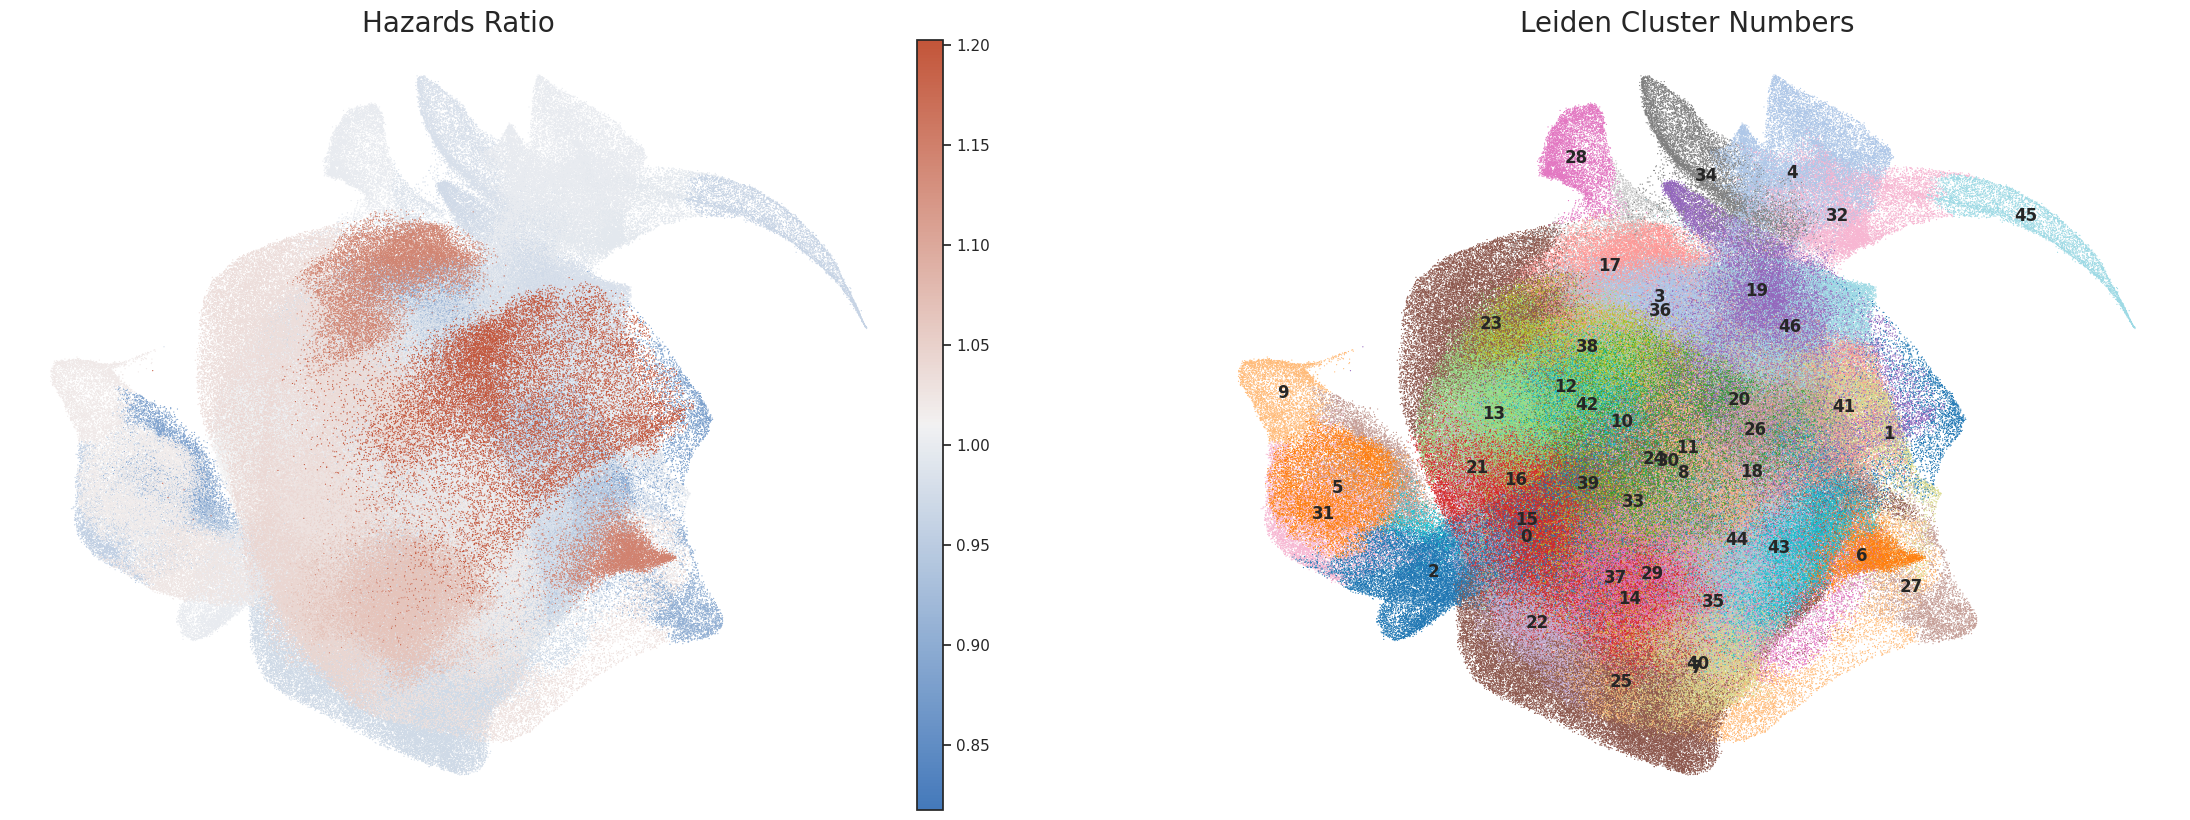

In [24]:
# fold 4
summary = cphs['2p0'][4].summary.reset_index()

# Adding Leiden Clustering info.
# h5_path_adata = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128_filtered/hdf5_{}_he_complete_combined_metadata_filtered.h5'.format(main_path, 'Meso_400_subsampled', 'Meso_400_subsampled')
h5_path_adata = h5_complete_path
meta_folder_adata = '750K'
groupby = 'leiden_2.0'
fold_number = 4
# adata_train, h5ad_path = read_h5ad_reference(h5_path_adata, meta_folder_adata, groupby, fold_number)
if os.path.isfile(h5ad_path.replace('.h5ad', '_paga.h5ad')):
    adata_train = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))

adata_train.obs['HR'] = adata_train.obs['leiden_2.0'].apply(lambda x: summary[summary['covariate'].astype(str) == str(x)]['exp(coef)'].values[0]).astype(float)
fig = plt.figure(figsize=(28,10))
ax1 = fig.add_subplot(121)
sc.pl.umap(adata_train, color='HR', show=False, size=3,  frameon=False, cmap=sns.diverging_palette(250, 20, as_cmap=True), title='Hazards Ratio', ax=ax1, legend_loc='best');
ax1.set_title('Hazards Ratio', fontsize=20)
ax2 = fig.add_subplot(122)
sc.pl.umap(adata_train, color='leiden_2.0', show=False, size=3,  frameon=False, title='Leiden Clusters', ax=ax2, legend_loc='on data', palette='tab20');
ax2.set_title('Leiden Cluster Numbers', fontsize=20)
plt.savefig('{}/hr_leiden_clusters.png'.format(figure_path), dpi=500, bbox_inches='tight')


## Kaplan Miere

In [198]:
# Removing the clusters manually
# leiden 1p5 fold 4
remove_1p5 = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
hpc_1p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

# leiden 2p0 fold 4
hpc_2p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
# remove_2p0 = [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 
# back to normal to get the association with all the clusters for the HR plot
remove_2p0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 2p5 fold 4
hpc_2p5 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
remove_2p5 = [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# leiden 3p0 fold 4
hpc_3p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
remove_3p0 = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# leiden 4p0 fold 4
hpc_4p0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
remove_4p0 = [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

dict_removal = {'1p5':[remove_1p5, hpc_1p5], '2p0':[remove_2p0, hpc_2p0], '2p5':[remove_2p5, hpc_2p5], '3p0':[remove_3p0, hpc_3p0], '4p0':[remove_4p0, hpc_4p0]}

	 Resolution: 2p0


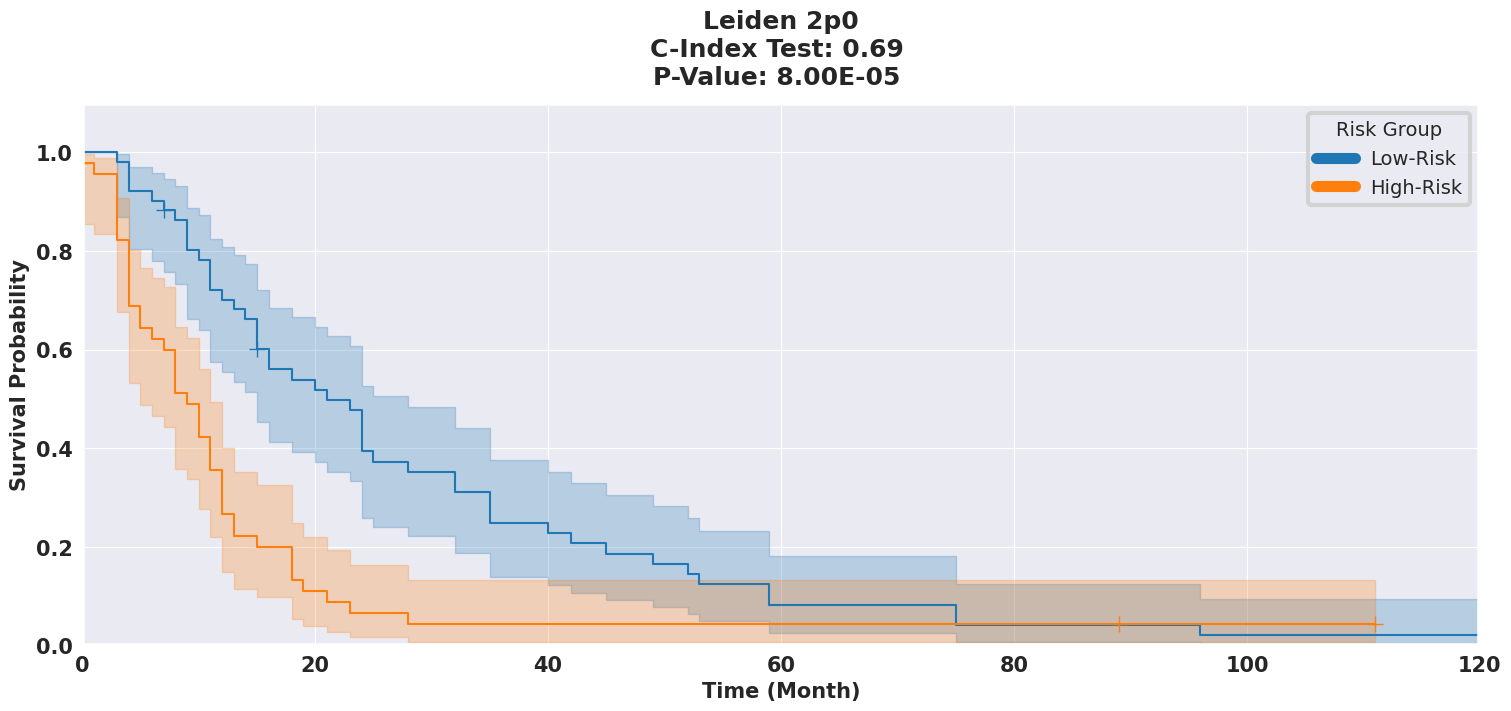

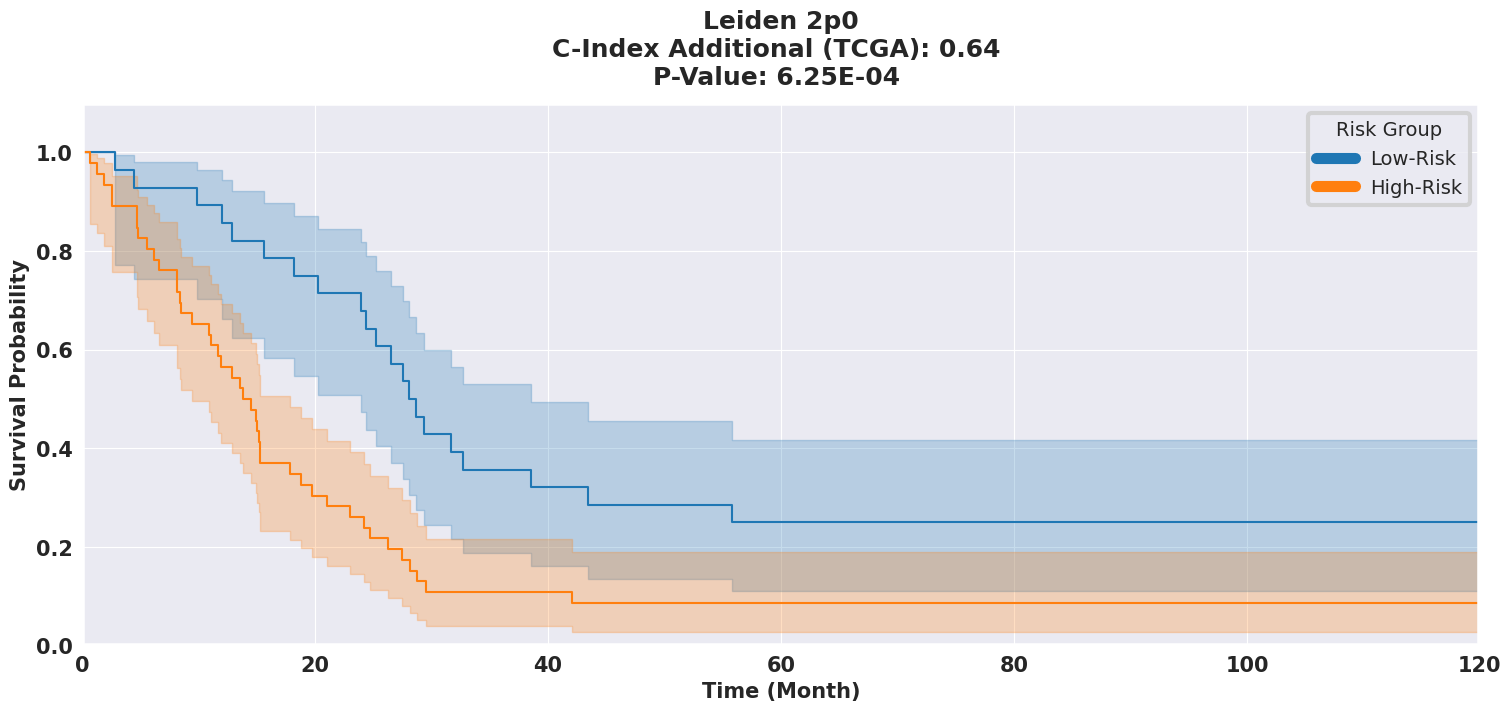

In [277]:
# Just for fold 4 and the clusters from removal list
penalizer = .5
l1_ratio = .1

# resolutions = ['1p5', '2p0', '2p5', '3p0', '4p0']
resolutions = ['2p0']
for resolution in resolutions:
        cis_list = []
        fold = 4
        test_risk = [pd.DataFrame(), pd.DataFrame()]
        additional_risk = [pd.DataFrame(), pd.DataFrame()]

        train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

        test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)

        additional = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_additional_metadata.csv'.format(main_path, dataset, meta_folder , resolution, fold), index_col=0)


        # remove this column from the train and test data
        leiden_clusters = []
        hpc, remove = dict_removal[resolution][1], dict_removal[resolution][0]
        for cluster, removal in zip(hpc, remove):
                if not removal: leiden_clusters.append(str(cluster))

        train_df = train[leiden_clusters + [event_data_field, event_ind_field]]
        test_df = test[leiden_clusters + [event_data_field, event_ind_field]]
        additional_df = additional[leiden_clusters + [event_data_field, event_ind_field]]

        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        cph.fit(train_df, duration_col='os_event_data', event_col='os_event_ind', robust=True)
        print('\t Resolution: {}'.format(resolution))
        cis_list.append(cph.score(train_df, scoring_method='concordance_index'))
        cis_list.append(cph.score(test_df, scoring_method='concordance_index'))
        cis_list.append(cph.score(additional_df, scoring_method='concordance_index'))
        #     cph.print_summary()
        #     cph.plot()

        # pval for the test and additional data and save the KMs
        train_df = train[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
        test_df = test[leiden_clusters + [event_data_field, event_ind_field, matching_field]]
        additional_df = additional[leiden_clusters + [event_data_field, event_ind_field, matching_field]]

        datas = [(train_df, 'train'), (test_df, 'test'), (additional_df, 'additional')]

        train_preds = cph.predict_partial_hazard(train_df)
        test_preds = cph.predict_partial_hazard(test_df)
        additional_preds = cph.predict_partial_hazard(additional_df)

        predictions = [(train_preds,'train'), (test_preds,'test'), (additional_preds,'additional')]


        high_lows = get_high_low_risks(predictions, datas, fold, matching_field, q_buckets=2)
        test_risk, additional_risk = combine_risk_groups(test_risk, additional_risk, high_lows, fold, num_folds, matching_field, event_ind_field, event_data_field)

        test_pval, additional_pval = save_fold_KMs(test_risk, additional_risk, resolution, 'leiden_{}'.format(resolution.replace('p','.')), np.array(cis_list), event_ind_field, event_data_field, 120, figure_path)



Adding Other metadata (Decrease the resulting scores for now - maybe over-fitting or cut-off some data due to common column | Needs to go through the )

# Cluster Significance

In [231]:
high_lows[0][1]

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,os_event_data,os_event_ind,case_Id,hazard,h_bin,h_bin_4
0,-1.166438,-0.844854,0.728957,0.855338,-0.896147,1.277407,-1.761145,-0.271054,-0.001134,-3.435121,...,0.496704,-0.001134,-3.032983,-0.314226,9.0,1,340,1.352674,1,1
2,-2.783101,-0.695013,1.459652,-0.033615,0.998306,0.195960,0.195960,1.893690,-1.165017,-2.783101,...,1.556279,-0.423079,-2.774455,0.058759,7.0,1,271,1.344562,1,1
6,-1.450361,-0.420741,0.307497,0.008254,2.635615,0.159077,0.307497,-0.142028,0.509734,-3.752946,...,1.106866,0.341399,-1.673504,1.322228,7.0,1,337,1.119230,1,1
7,0.738996,-0.842790,0.485008,-0.083685,-3.933832,1.063380,-2.142073,-0.889310,1.746340,-3.066858,...,-0.002007,-0.842790,-3.066858,-0.127170,12.0,1,264,1.227415,1,1
8,-2.930559,-0.851117,-1.321121,1.103682,0.226442,-3.623706,-1.544264,-2.014268,0.783013,-2.941717,...,0.720100,-1.677796,0.550681,2.399742,32.0,1,255,1.181061,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1.354811,-1.081849,-0.751607,0.695312,-2.425583,-1.509293,0.483137,0.293517,-0.456143,-4.217343,...,1.384776,-0.325523,-2.271433,0.427048,0.0,1,158,1.347357,1,1
372,0.825777,1.113459,-2.282281,-2.282281,-2.282281,-0.272835,0.420312,0.420312,2.946041,-2.282281,...,-0.272835,2.366222,-2.282281,-2.282281,7.0,1,177,1.218735,1,1
376,1.324746,-0.577362,0.452258,-0.482051,-2.300110,1.324746,1.820534,2.244017,-0.934037,-0.577362,...,3.049642,-0.395040,-2.300110,0.010425,18.0,1,167,1.114922,1,1
377,-2.080515,-2.413470,0.582263,-1.314857,-1.720322,-2.080515,2.833555,2.348704,-1.720322,-2.080515,...,2.171498,-2.080515,-2.080515,3.177517,10.0,1,102,1.238577,1,1


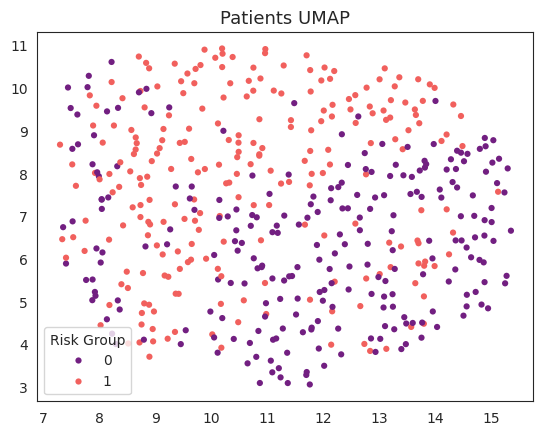

In [242]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
# for train and test data
temp = pd.concat([high_lows[0][1], high_lows[0][0], high_lows[1][1], high_lows[1][0]], axis=0)
reducer = umap.UMAP(random_state=42, metric='correlation' , n_neighbors=20, min_dist=.5, verbose=False)

embedding = reducer.fit_transform(temp.drop(['h_bin','h_bin_4', 'hazard', 'os_event_data',	'os_event_ind'	,'case_Id'], axis=1).values)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=temp.h_bin, palette='magma', s=20, alpha=1.0, edgecolors='none');
plt.legend(loc='lower left', title='Risk Group')
plt.title('Patients UMAP', fontsize=13)
plt.savefig('{}/umap_patients.png'.format(figure_path), dpi=500, bbox_inches='tight')

### Forest Plots

In [272]:
# Reading annotations.
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()

#  resoltuion 2.0 and Fold 0
model = cph
results_df = model.summary
results_df['hpc'] = results_df.index
results_df = results_df.sort_values(by='coef', ascending=False).reset_index(drop=True)


significance = 0.05
results_df_signfcnt = results_df[results_df['p'] < significance]
death_clusters = results_df_signfcnt[results_df_signfcnt['coef'] > 0].sort_values(by='coef', ascending=False)
alive_clusters = results_df_signfcnt[results_df_signfcnt['coef'] < 0].sort_values(by='coef', ascending=True)
print('Death clusters: ', death_clusters['hpc'].values)
print('Alive clusters: ', alive_clusters['hpc'].values)




# export needed tiles
im_list_dict = dict()
for class_ in ['death', 'alive']:
    im_list = []
    if class_ == 'death': cluster_set = death_clusters.hpc.astype('str')
    elif class_ == 'alive': cluster_set = alive_clusters.hpc.astype('str')
    for cluster_number in cluster_set:
        if cluster_number.split('_')[0] in categorical_cols: im_list.append((None, cluster_number))
        else:
            indexes, sets = adata_train[adata_train.obs[groupby] == cluster_number].obs['indexes'], adata_train[adata_train.obs[groupby] == cluster_number].obs['original_set']
            i_rand = np.random.randint(0, len(indexes))
            index_ = indexes[i_rand]
            set_ = sets[i_rand]
            if set_ == 'valid': set_address = 'validation' 
            else: set_address = set_
            h5_image_path = h5_complete_path.split('results/')[0] + 'datasets/{}/he/patches_h224_w224/hdf5_Meso_he_{}.h5'.format('Meso', set_address)
            h5_image = h5py.File(h5_image_path, 'r')
            im_list.append((h5_image['{}_img'.format(set_)][int(index_)], cluster_number))
            h5_image.close()
    im_list_dict[class_] = im_list

Death clusters:  ['15' '22']
Alive clusters:  ['10' '27']


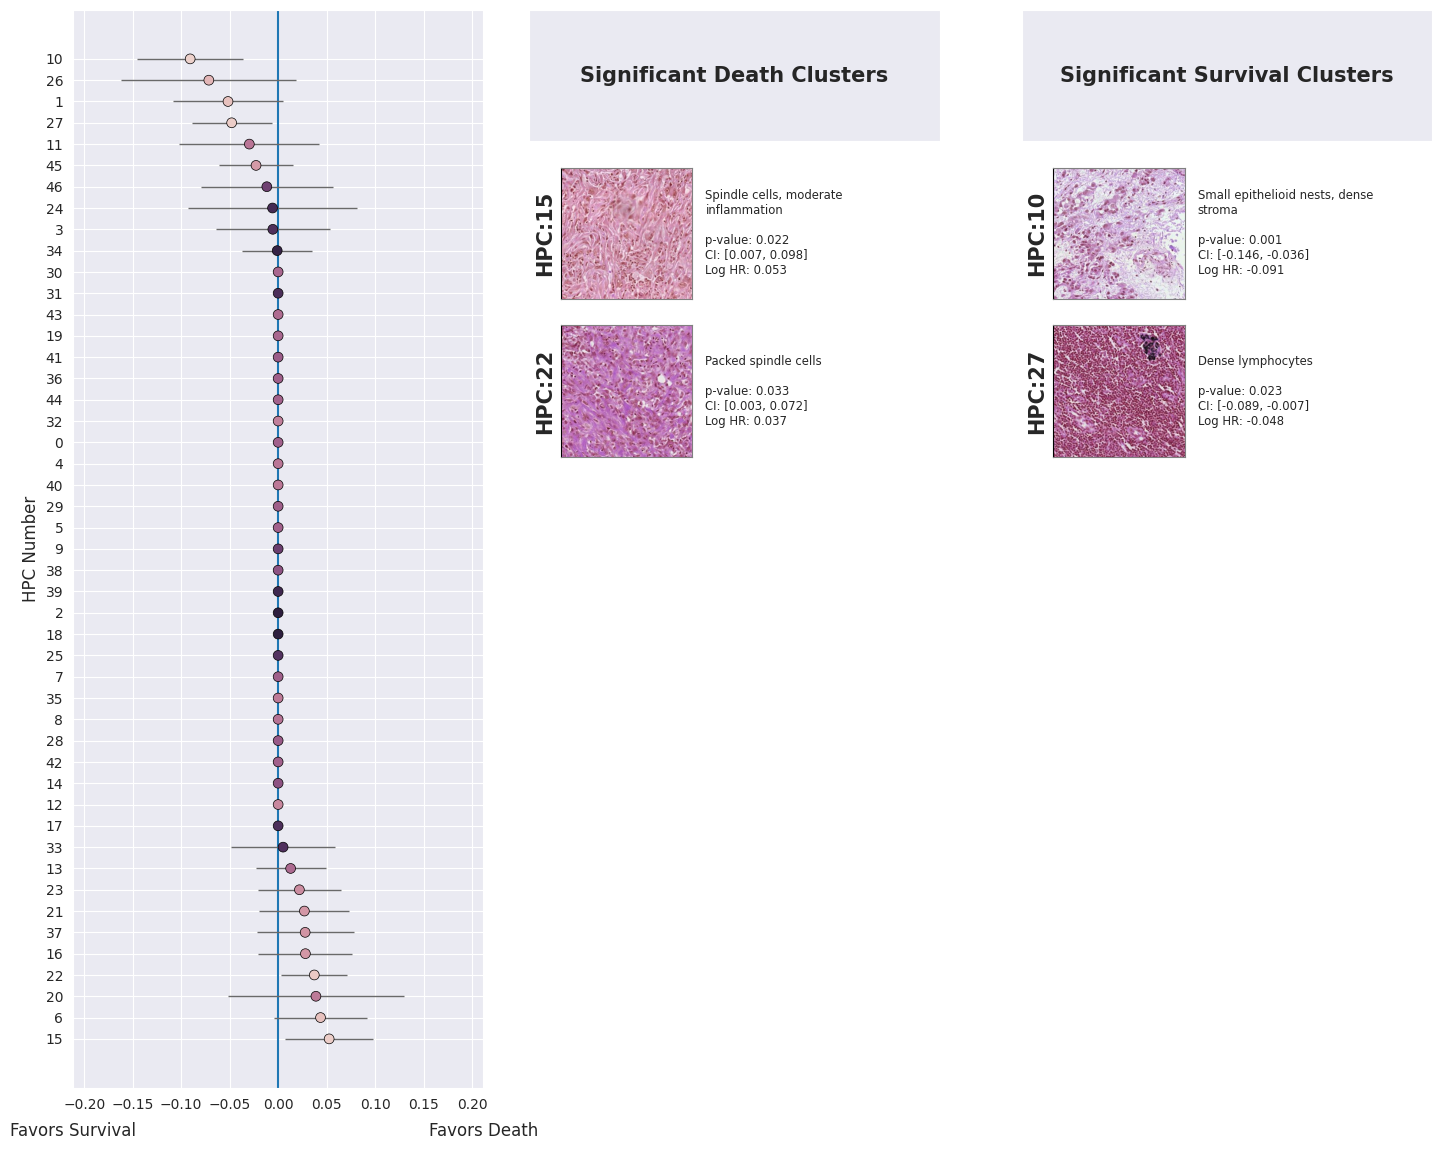

In [273]:
import textwrap
sns.set_style("darkgrid")

#  Forest Plot
center = 0.0
effect_measure = results_df['coef'].values.astype(str).astype(float)
lower = results_df['coef lower 95%'].values
upper = results_df['coef upper 95%'].values
diff_upper = upper - effect_measure
diff_lower = effect_measure - lower

ncol, nrow = 3, 7
fig = plt.figure(figsize=(6*ncol, 2*nrow))
gs = fig.add_gridspec(nrow, ncol)
ax1 = fig.add_subplot(gs[:, 0])


fontsize = 12
plot = sns.scatterplot(data=results_df, x='coef', y=results_df.index, hue='p', sizes=(20, 200), legend=False, zorder=3, edgecolor='black', linewidth=0.5, s=50, ax=ax1)
plot.set_yticklabels(results_df['hpc'])
plot.set_yticks(results_df.index)
plot.axvline(center, zorder=1)
plot.errorbar(effect_measure, results_df.index, xerr=[diff_upper, diff_lower], marker='None',zorder=2, ecolor='dimgrey', elinewidth=1, linewidth=0)

plot.set_xlabel('', fontsize=fontsize)
plot.set_ylabel('HPC Number', fontsize=fontsize)
max_value = max(abs(max(upper)), abs(min(lower)))
plot.set_xlim([-max_value-.05, max_value+.05])
plot.text(0.0, -.04, textwrap.fill('Favors Survival',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize)
plot.text(1.0, -.04, textwrap.fill('Favors Death',30), horizontalalignment='center', verticalalignment='center', transform=plot.transAxes, fontsize=fontsize);
################################################################################################################################ 



# Legends
annot_flag = True
for class_ in ['death', 'alive']:
    im_list = im_list_dict[class_]
    if class_=='death': 
        i, j = 0, 1
        title = 'Significant Death Clusters'
    else: 
        i, j = 0, 2
        title = 'Significant Survival Clusters'
    ax = fig.add_subplot(gs[i,j])
    ax.set(xticks=[], yticks=[])
    ax.text(0.5, 0.5, textwrap.fill(title, 30), fontsize=15, ha='center', va='center', weight='bold')
    pos = ax.get_position()
    ax.set_position([pos.x0-.02, pos.y0, pos.width, pos.height])
    i+=1

    for (image, cluster_number) in im_list:
        ax = fig.add_subplot(gs[i, j])
        if image is not None:
            ax.imshow(image)
        else:
            cluster_number = cluster_number.split('_')[0]
        ax.set(xticks=[], yticks=[])
        # ax.set_title('Cluster {}'.format(cluster_number), fontsize=fontsize)
        i += 1

        ax.set_ylabel('HPC:{}'.format(cluster_number), fontdict=dict(weight='bold', size=15))
        ax.set_axis_on()
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        pos = ax.get_position()
        ax.set_position([pos.x0-.08, pos.y0, pos.width, pos.height])

        p_value = results_df[results_df['hpc']==cluster_number]['p'].values[0]
        log_HR = results_df[results_df['hpc']==cluster_number]['coef'].values[0]
        CI = [results_df[results_df['hpc']==cluster_number]['coef lower 95%'].values[0], results_df[results_df['hpc']==cluster_number]['coef upper 95%'].values[0]]
        if cluster_number.split('_')[0] in categorical_cols: 
            label_text = 'Feature: {}'.format(cluster_number)
        else:
            if annot_flag: annotation_text = textwrap.fill(annotations[annotations['HPC']==int(cluster_number)]['Summary'].values[0], 30)
            else: annotation_text = ''
            label_text = annotation_text + '\n \n'+ 'p-value: {}'.format(np.round(p_value, 3)) + '\n' + 'CI: [{}, {}]'.format(np.round(CI[0], 3), np.round(CI[1], 3)) + '\n' + 'Log HR: {}'.format(np.round(log_HR, 3))
        
        ax.text(1.1, .5, label_text,
                transform=ax.transAxes,
                horizontalalignment="left", verticalalignment="center", size="small", )

plt.savefig(os.path.join(figure_path,'forest_plot_survival_annotated.png'), dpi=500, bbox_inches='tight')

In [274]:

# # Mine
# for resolution in ['2p0']:
#     sns.set_theme(style='white')
#     plt.rcParams["axes.grid"] = True
#     plt.rcParams["axes.facecolor"] = '#f3e9de'
#     mosaic = '''123
#                 456'''
#     fig = plt.figure(figsize=(20,20), constrained_layout=True)
#     ax_dict = fig.subplot_mosaic(mosaic, sharex=False, sharey=False)


#     cphs_temp = []
#     alpha = []
#     for key in cphs[resolution].keys():
#         cphs_temp.append(cphs[resolution][key])
#         alpha.append(cphs[resolution][key].penalizer)
#     for i, estimator in enumerate(cphs_temp):
#         ax_dict[str(i+1)].set_title('Resolution %s (Fold %s)- Alpha %s\nC-Index %s' % (resolution.replace('p', '.'),i, np.round(alpha[i],2), np.round(np.array(cis[resolution]).T[i][2],2)))
#         estimator.plot(ax=ax_dict[str(i+1)])

Saving CIs and a boxplot for them.

In [275]:
df_summary_all = pd.DataFrame()
for resolution in resolutions:
    for fold in cphs[resolution].keys():
        for set_name in ['train', 'test', 'additional']:
            row = []
            df_summary = pd.DataFrame()
            row.append(resolution.replace('p', '.'))
            row.append(fold)
            row.append('C-Index '+ set_name)
            if set_name == 'train':
                row.append(np.round(np.array(cis[resolution]).T[int(fold)][0],2))
            elif set_name == 'test':
                row.append(np.round(np.array(cis[resolution]).T[int(fold)][1],2))
            else:
                row.append(np.round(np.array(cis[resolution]).T[int(fold)][2],2))
            row.append(cphs[resolution][fold].penalizer)
            df_summary_all = pd.concat([df_summary_all, pd.DataFrame([row])], ignore_index=True)
df_summary_all.rename(columns={0:'Resolution', 1:'Fold', 2:'Set', 3:'C-Index', 4:'Alpha'}, inplace=True)
        

TypeError: list indices must be integers or slices, not str

In [130]:
# C-Index mean and confidence interval figure.
def mean_ci_cox(all_data, ylim=[0.4, 1.0]):
	sns.set_theme(style='darkgrid')
	fig, ax = plt.subplots(figsize=(20, 7), nrows=1, ncols=1)
	sns.pointplot(x='Resolution', hue='Set', y='C-Index', data=all_data, ax=ax, dodge=.3, join=False, capsize=.04, markers='s', errorbar=('ci', 95))
	if ylim is not None:
		ax.set_ylim(ylim)
	ax.set_title('Cox Regression', fontweight='bold', fontsize=18)
	ax.legend(loc='upper left')
	start, end = ax.get_ylim()
	ax.yaxis.set_ticks(np.arange(start, end, 0.05))

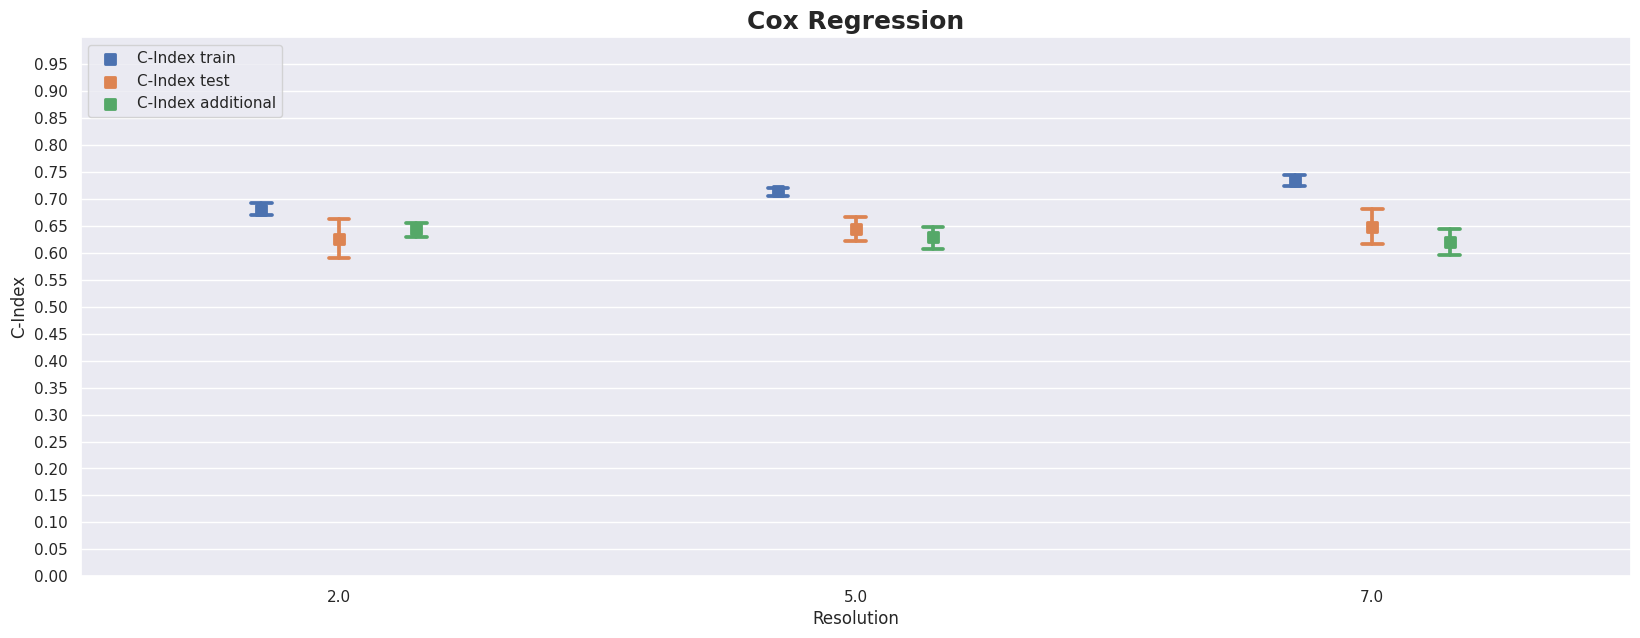

In [131]:
mean_ci_cox(df_summary_all, ylim=[0.0, 1.0])

In [103]:
summary_table = cphs['2p0'][0].summary
summary_table.sort_values(by='p', ascending=True, inplace=True)
hpc_columns = summary_table.index.values[:4] # First four highly significant HPCs
p_hpc_columns = summary_table['p'].values[:4]
print('Highly Significance HPCs in Survival:', hpc_columns, 'P values:', p_hpc_columns)
summary_table

Highly Significance HPCs in Survival: ['7' '15' '38' '16'] P values: [1.99905617e-05 6.65542226e-03 1.92771377e-02 2.80220466e-02]


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
7,-2.416325e-01,0.785345,0.056655,-0.352674,-0.130591,0.702806,0.877576,0.0,-4.264996,0.000020,15.610321
15,9.916176e-02,1.104245,0.036542,0.027540,0.170783,1.027923,1.186234,0.0,2.713611,0.006655,7.231254
38,1.120230e-01,1.118539,0.047870,0.018199,0.205847,1.018365,1.228566,0.0,2.340128,0.019277,5.696965
16,8.298719e-02,1.086528,0.037773,0.008953,0.157022,1.008993,1.170021,0.0,2.196978,0.028022,5.157294
18,-7.390674e-02,0.928758,0.037288,-0.146989,-0.000824,0.863303,0.999176,0.0,-1.982070,0.047471,4.396798
4,-9.635593e-02,0.908141,0.049710,-0.193785,0.001073,0.823835,1.001074,0.0,-1.938369,0.052578,4.249391
40,-8.515429e-02,0.918371,0.049667,-0.182500,0.012192,0.833184,1.012266,0.0,-1.714494,0.086438,3.532191
31,8.369130e-02,1.087293,0.052333,-0.018879,0.186261,0.981299,1.204737,0.0,1.599221,0.109771,3.187426
26,-1.049660e-01,0.900355,0.069872,-0.241912,0.031980,0.785125,1.032497,0.0,-1.502269,0.133028,2.910201


Adding Annotations alongside the forest plot for leiden2.0 fold 0

## Get WSI in with top 10 clusters (2high-2low risk patients)

In [19]:
from models.clustering.correlations import *
from models.clustering.data_processing import *


dataset = 'Meso_500'
additional_dataset = 'TCGA_MESO'
meta_folder     = 'survival'
matching_field  = 'case_Id'
groupby         = 'leiden_2.0'
fold_number     = 4


h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128_filtered/hdf5_{}_he_complete_metadata_filtered.h5'.format(main_path, dataset, dataset)
# h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128_filtered/hdf5_{}_he_complete_metadata.h5'.format(main_path, dataset, additional_dataset)
adatas_path = h5_complete_path.split('/hdf5_')[0] + '/{}/adatas/'.format(meta_folder)
# survival_csvs_path = h5_complete_path.split('/hdf5_')[0] + '/{}/survival_csvs'.format(meta_folder)
patient_csv = '{}/files/Meso_patients.csv'.format(main_path)

In [30]:
''' ###### Visualize WSI Cluster Samples ######### '''
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    # if TCGA-MESO put - instead of _.
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, groupby, slide, img_size, downsample, img_dicts, colors, pad_pixels=50, legend_margin=1000):
    slide_indices  = frame[frame.slides==slide].indexes.values.tolist()
    slide_tiles    = frame[frame.slides==slide].tiles.values.tolist()
    slide_sets     = frame[frame.slides==slide].original_set.values.tolist()
    slide_clusters = frame[frame.slides==slide][groupby].values.tolist()

    # Get size of the WSI.
    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set, cluster in zip(slide_indices, slide_tiles, slide_sets, slide_clusters):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)

        if cluster == 'Others':
            color = colors[-1]
        else:
            color = colors[int(cluster)]
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    wsi_padded = np.pad(wsi[:, :, 0], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_padded_total = np.zeros(list(wsi_padded.shape) + [3])
    wsi_padded_total[:, :, 0] = wsi_padded
    wsi_padded_total[:, :, 1] = np.pad(wsi[:, :, 1], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_padded_total[:, :, 2] = np.pad(wsi[:, :, 2], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')

    wsi_padded = np.pad(wsi_c[:, :, 0], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_c_padded_total = np.zeros(list(wsi_padded.shape) + [3])
    wsi_c_padded_total[:, :, 0] = wsi_padded
    wsi_c_padded_total[:, :, 1] = np.pad(wsi_c[:, :, 1], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    wsi_c_padded_total[:, :, 2] = np.pad(wsi_c[:, :, 2], ((pad_pixels, pad_pixels), (pad_pixels, pad_pixels+legend_margin)), 'maximum')
    return wsi_padded_total, wsi_c_padded_total, slide_clusters


In [21]:
from data_manipulation.data import Data
data = Data(dataset=dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images


Meso_500


In [46]:
clustered_df

,case_Id,os_event_data,os_event_ind,0,1,2,3,4,5,6,...,36,37,38,39,40,type,age,Sex,stage,hazard
8,367,1.0,1,1.917364,1.255027,0.168477,1.060003,-1.630503,1.529269,0.283859,...,0.910757,-3.156559,1.600474,0.623075,-2.995088,Biphasic,36,Female,N2,5.113036
257,165,4.0,1,2.372239,-0.161458,3.734436,1.524941,-1.910867,2.519564,-0.161458,...,-1.910867,-1.910867,2.057746,0.426329,-0.672283,Biphasic,70,Male,Not given (Nx),4.883582
53,342,13.0,1,2.363550,0.745062,1.317581,1.997825,0.682542,1.720194,-0.879643,...,-2.751445,-3.444592,1.255888,-2.345980,-2.905348,Biphasic,55,Male,N1,3.846125
187,292,7.0,1,-0.252516,-1.993855,-1.993855,-1.993855,-1.993855,-1.993855,-0.252516,...,-1.993855,2.386541,-1.993855,-1.993855,-1.993855,Epithelioid,79,Female,Not given (Nx),3.642153
268,112,12.0,1,2.900988,0.013889,1.484741,3.956042,-1.209886,1.702465,1.241119,...,-2.275516,-2.126177,-0.334417,-2.819324,-0.622099,Biphasic,68,Male,Not given (Nx),3.389692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,498,59.0,1,-0.153871,2.005613,2.317049,-1.252483,2.689098,1.189864,2.461089,...,4.471102,-0.559336,-1.945631,-0.847018,-1.252483,Epithelioid,74,Male,N0,0.265624
71,86,67.0,0,0.142993,3.262049,3.015852,0.505899,2.566136,1.640102,3.670273,...,-2.185224,-0.757793,-3.322742,0.340819,-3.322742,Epithelioid,67,Male,N0,0.251297
279,147,8.0,1,0.491088,3.356458,1.759599,-0.607525,2.748210,1.626067,2.264155,...,-2.112200,-1.706137,-2.112200,4.247106,1.429357,Epithelioid,72,Male,Not given (Nx),0.250278
79,361,99.0,1,0.819066,2.851211,2.288742,0.168479,2.327963,1.307913,2.733428,...,3.153740,0.774614,-3.009575,1.384874,-0.930134,Epithelioid,60,Male,N0,0.206369


In [47]:
# Selecting the high_low risk slide and patients

clustered_df, _ = datas['2p0'][0][0]
clustered_df['hazard'] = cphs['2p0'][0].predict_partial_hazard(clustered_df.drop(['case_Id']+categorical_cols+normalize_cols, axis=1))
clustered_df.sort_values(by='hazard', ascending=False, inplace=True)
high_0, high_1 = clustered_df['case_Id'].values[:2]
low_0, low_1 = clustered_df['case_Id'].values[-2:]
print('low hazrads patients:', low_0, low_1)
print('high hazards patients', high_0, high_1)
for id in [low_0, low_1, high_0, high_1]:
    print('Case Id:',id)
    print(frame_clusters[frame_clusters.case_Id==id].samples.unique())


low hazrads patients: 361 124
high hazards patients 367 165
Case Id: 361
['MESO_361_21' 'MESO_361_19' 'MESO_361_30' 'MESO_361_28' 'MESO_361_24'
 'MESO_361_20']
Case Id: 124
['MESO_124_21' 'MESO_124_20' 'MESO_124_18' 'MESO_124_27' 'MESO_124_19'
 'MESO_124_25']
Case Id: 367
['MESO_367_31' 'MESO_367_25' 'MESO_367_27' 'MESO_367_28' 'MESO_367_26'
 'MESO_367_30' 'MESO_367_12' 'MESO_367_29' 'MESO_367_13']
Case Id: 165
['MESO_165_11' 'MESO_165_4' 'MESO_165_9']


In [ ]:
# Taking slide and tile data from unfiltered dataset.
h5_path_temp = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_metadata.h5'.format(main_path, dataset, dataset)
frame, dim_columns, rest_columns = representations_to_frame(h5_path_temp, meta_field='case_Id')
df_tile_slide_set = frame[['slides', 'case_Id', 'tiles', 'indexes', 'original_set']]

# Taking the slide and tile HPC numbers from adatas
adatas_path_whole = h5_complete_path.split('/hdf5_')[0] + '/{}/adatas/'.format(meta_folder)
_, frame_clusters, leiden_clusters_whole = read_csvs(adatas_path_whole, matching_field, groupby, fold_number, [[''],[''],['']], h5_complete_path, None, additional_as_fold=False, force_fold=None)
from IPython.display import clear_output
clear_output()

In [ ]:
# from models.visualization.clusters import get_wsi_arrays
from skimage.transform import resize
from matplotlib.lines        import Line2D
# 'MESO_165_4', 'MESO_361_28', 'MESO_367_31', 'MESO_367_26', 'MESO_367_30', 'MESO_165_11'
slides = ['MESO_165_4', 'MESO_361_28', 'MESO_367_31', 'MESO_367_26', 'MESO_367_30', 'MESO_165_11' ]

groupby = 'leiden_2.0'
for slide in slides:
    # Extracting 10 top HPCs for each slide
    temp = frame_clusters[frame_clusters.slides == slide]
    ten_top_hpc = temp[groupby].value_counts().head(10)
    goal_clusters_df = temp[temp[groupby].isin(ten_top_hpc.index.values)]
    goal_clusters_df = goal_clusters_df[[groupby, 'slides', 'tiles']]

    final_df = df_tile_slide_set.merge(goal_clusters_df, on=['slides', 'tiles'], how='outer')
    final_df[groupby] = final_df[groupby].fillna('Others')

    
    colors_ = np.unique(frame_clusters[groupby].astype(float).astype(str).values).tolist() + ['Others']
    colors = sns.color_palette('Paired', len(colors_))

    wsi, wsi_c, slide_clusters = get_wsi_arrays(final_df, groupby, slide, img_size=224, downsample=2, img_dicts=data_dicts, colors=colors, pad_pixels=0, legend_margin=1000)
    fontsize   = 45
    markersize = 15
    image_clusters, counts = np.unique(slide_clusters, return_counts=True)


    # for index in np.argsort
    # custom_lines = [Line2D([0], [0], color=, lw=markersize) for index in np.argsort(-counts)]
    
    names_lines, color_lines  = [], []
    others_flag = False
    for index in np.argsort(-counts):
        hpc = image_clusters[index]
        if hpc == 'Others':
            others_flag = True
        else:
            hpc = hpc.astype(float).astype(int)
            color = colors[hpc]
            annotations = pd.read_csv('{}/files/Meso_400_subsampled_annotations.csv'.format(main_path))
            ann_hpc = textwrap.fill(annotations[annotations['HPC'] == hpc]['Summary'].values[0] + ' ({})'.format(annotations[annotations['HPC'] == hpc]['main_pattern'].values[0]), width=80)
            ratio = goal_clusters_df[goal_clusters_df[groupby]==hpc].shape[0]/goal_clusters_df.shape[0]
            name = 'HPC %2s - Area(%s) %3s - %s' % (hpc, '%',np.round(ratio*100,2), ann_hpc)
            names_lines.append(name)
            color_lines.append(Line2D([0], [0], color=color, lw=markersize))
    
    if others_flag: 
        names_lines.append('Others')
        color_lines.append(Line2D([0], [0], color=colors[-1], lw=markersize))
    fig = plt.figure(figsize=figsize)
    for (_wsi, wsi_name) in [(wsi,'wsi'), (wsi_c,'wsi_c')]:
        dpi = 100
        height, width, _ = _wsi.shape
        figsize = width / float(dpi), height / float(dpi)
        
        
        if wsi_name == 'wsi_c':
            ax  = fig.add_subplot(1, 2, 1)
            
            legend = ax.legend(color_lines, names_lines, title='Histomorphological Phenotype Cluster\n(HPC)', loc='center left', ncol=1,
                            prop={'weight':'bold', 'size':fontsize}, title_fontproperties={'weight':'bold', 'size':fontsize*1.2}, bbox_to_anchor=(0.25, 1.5),fancybox=True, shadow=True)
            legend.get_frame().set_linewidth(5)
        elif wsi_name == 'wsi':
            ax  = fig.add_subplot(1, 2, 2)
            legend = None
        
        ax.imshow(_wsi/255.)
        ax.axis('off')

    plt.show(fig)
    plt.close(fig)
        # save figure
        # fig.savefig(figure_path + '/%s_%s_%s_legend.jpg' % (whole_dataset, meta_folder, wsi_name), bbox_inches='tight', pad_inches=0)